In [1]:
# Import Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
from itertools import cycle
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display
from scipy import stats

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence, select_months
from eofs import *
from ar_funcs import get_AR_days
from kmeans import *
import nclcmaps as ncl

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
## Select MERRA2 or ERA5
reanalysis = 'era5'

# # if using single bound box
# bound_box = [20, 40, 65, 95]
# trackIDs, df = get_ar_days(reanalysis, start_date, end_date, subregions=False, bbox=bound_box, thresh=None)
# df

# if using 3 subregions and threshold
trackIDs, df = get_ar_days(reanalysis, start_date, end_date, subregions=True, bbox=None, thresh=0.3)
df

,R01,R02,R03,R04,track_id,ar,location
time,,,,,,,
1979-12-01,0.198980,0.0,0.336735,0.223416,2864.0,1,R03
1979-12-02,0.346939,0.0,0.035714,0.163462,2864.0,1,R01
1979-12-03,0.005102,0.0,0.000000,0.005656,2879.0,0,NaN
1979-12-04,0.000000,0.0,0.000000,0.000000,NaN,0,NaN
1979-12-05,0.000000,0.0,0.000000,0.000000,NaN,0,NaN
...,...,...,...,...,...,...,...
2019-05-27,0.000000,0.0,0.000000,0.000000,NaN,0,NaN
2019-05-28,0.000000,0.0,0.000000,0.000000,NaN,0,NaN
2019-05-29,0.000000,0.0,0.000000,0.010181,128807.0,0,NaN


In [4]:
# how many ARs in HMA between start date and end date?
print('Number of ARs between 1979 and 2019: ', df.ar.sum())
# how many ARs on average per year?
print('Average number of ARs per year: ', df.ar.sum()/39.)

Number of ARs between 1979 and 2019:  1375
Average number of ARs per year:  35.256410256410255


### Annual Climatology

In [5]:
clim_ct = df.ar.groupby(df.index.month).sum()
clim_ct

time
1     110
2     157
3     216
4     118
5      58
6     172
7     165
8      90
9      72
10     64
11     53
12    100
Name: ar, dtype: int64

/home/nash/DATA/repositories/AR_types/figs/ar_barplot.png


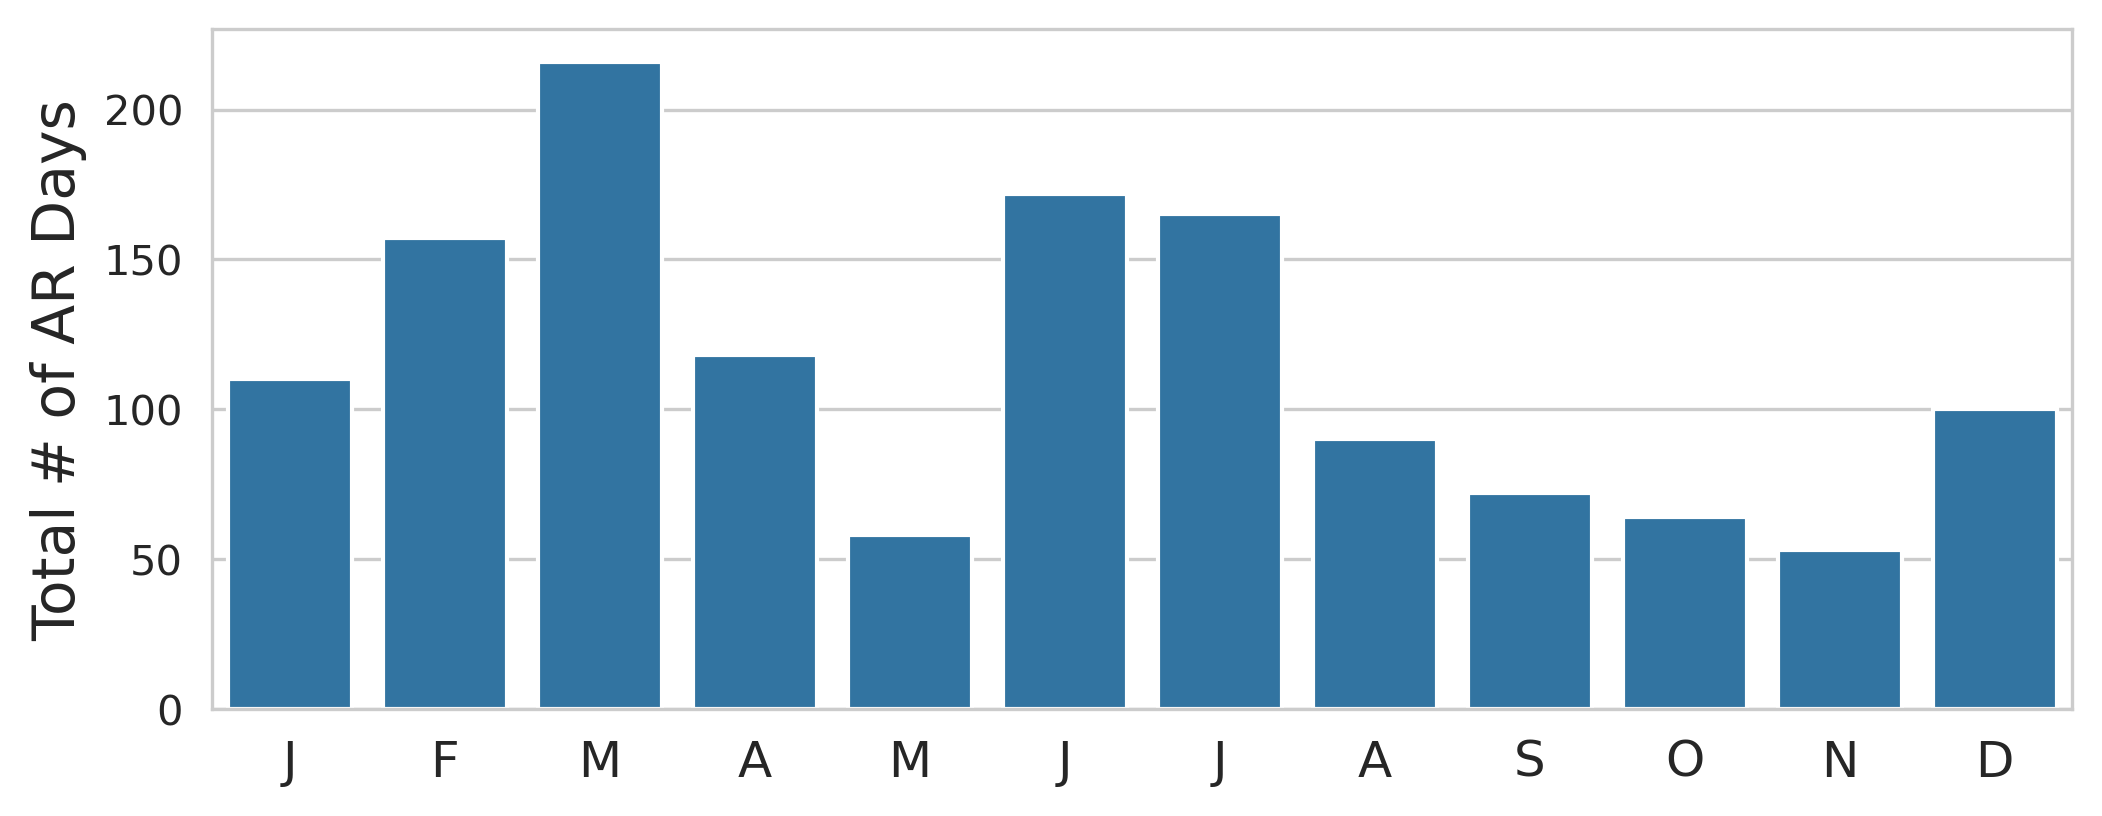

<Figure size 2400x900 with 0 Axes>

In [6]:
fname = path_to_figs + 'ar_barplot'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((8.0,3.0))
fig.dpi = 300
nplots=1

# Set custom color palette
colors = ["#003660"]
sns.set_palette(sns.color_palette(colors))
columns=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
          
sns.set_style("whitegrid")
# sns.set_context("paper")
sns.despine()

for i in np.arange(nplots):
    ax = fig.add_subplot(1, 1, i+1)
    sns.barplot(x=np.arange(1, 13, 1), y=clim_ct, color='tab:blue')
#     ax.set_title('AR Frequency (1980-2015)', fontsize=12)
    ax.set_ylabel('Total # of AR Days', fontsize=14)
    ax.set_xticklabels(columns, fontsize=12)
#     ax.legend(loc='upper left')
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

### Select ARs by Season

In [7]:
# select only rows with AR covering > 30% of area
idx = (df.ar > 0)
df_tmp = df.loc[idx]
print(len(df_tmp))
djf_df = select_months(df_tmp, 12, 2)
mam_df = select_months(df_tmp, 3, 5)
djfmam_df = select_months(df_tmp, 12, 5)

print('Number of unique events based on tracking algorithm: ')
print('DJF: ', djf_df['track_id'].nunique())
print('MAM: ', mam_df['track_id'].nunique())
print('DJFMAM: ', djfmam_df['track_id'].nunique())

print('Number of AR days: ')
print('DJF: ', len(djf_df))
print('MAM: ', len(mam_df))
print('DJFMAM: ', len(djfmam_df))

1375
Number of unique events based on tracking algorithm: 
DJF:  239
MAM:  300
DJFMAM:  538
Number of AR days: 
DJF:  367
MAM:  392
DJFMAM:  759


In [35]:
## write djfmam dates and trackID to csv in out folder
# Export dataframe as csv
outfile = path_to_out + 'DJFMAM_ARS_TRACKID.csv'
tmp = djfmam_df.drop(['R01', 'R02', 'R03', 'R04', 'ar', 'location'], axis=1)
tmp.to_csv(outfile)
print(outfile)
tmp.head()

/home/nash/DATA/repositories/AR_types/out/DJFMAM_ARS_TRACKID.csv


,track_id
time,
1979-12-01,2864.0
1979-12-02,2864.0
1980-01-24,3253.0
1980-02-12,3401.0
1980-02-13,3401.0


### Check duration of ARs based on trackID

In [8]:
## duration of ARs based on trackID
# for each AR Track ID, find the duration of that track
filename =  path_to_data + 'ar_catalog/globalARcatalog_ERA-Interim_1979-2019_v3.0.nc'
ds = xr.open_dataset(filename, engine='netcdf4')
ds = ds.squeeze()
# start-end dates
start_date = '1979-12-01 0:00'
end_date = '2019-05-31 18:00'
ds = ds.sel(time=slice(start_date, end_date))
# Select months
idx = (ds.time.dt.month >= 12) | (ds.time.dt.month <= 5)
ds = ds.sel(time=idx)
da = ds.kidmap
da


<xarray.DataArray 'kidmap' (time: 29160, lat: 121, lon: 240)>
[846806400 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * lat      (lat) float64 -90.0 -88.5 -87.0 -85.5 -84.0 ... 85.5 87.0 88.5 90.0
    lev      float64 1e+03
  * time     (time) datetime64[ns] 1979-12-01 ... 2019-05-31T18:00:00
    ens      float64 1.0
Attributes:
    long_name:  Track ID
    units:      none

In [9]:
# get list of unique track_ids for HMA ARs
print(djfmam_df.track_id.nunique())

track_ids = djfmam_df.track_id.unique()
track_ids

538


array([  2864.,   3253.,   3401.,   3540.,   3553.,   3580.,   3591.,
         3603.,   3719.,   3813.,   3831.,   3943.,   3995.,   6125.,
         6214.,   6431.,   6607.,   6752.,   6760.,   6783.,   7051.,
         7232.,   7472.,   9226.,   9605.,   9680.,   9758.,   9994.,
        10082.,  10064.,  10422.,  12271.,  12631.,  12649.,  12929.,
        12918.,  12973.,  13082.,  13101.,  13147.,  13131.,  13266.,
        13275.,  13313.,  13439.,  13703.,  15626.,  15805.,  16053.,
        16065.,  16233.,  16264.,  16295.,  16361.,  16373.,  18520.,
        18555.,  18567.,  18588.,  18606.,  19211.,  19341.,  21526.,
        21628.,  21996.,  22188.,  22249.,  22358.,  22367.,  22472.,
        22535.,  24571.,  24760.,  25143.,  25313.,  25358.,  25429.,
        25426.,  25471.,  25496.,  25529.,  25562.,  25639.,  25611.,
        25659.,  27731.,  27685.,  27845.,  28022.,  28230.,  28300.,
        28310.,  28248.,  28409.,  28433.,  28444.,  28494.,  28524.,
        28941.,  289

In [10]:
# create list of lists of trackIDs for each time step
date_lst = da.time.values
final_lst = []
for i, ids in enumerate(date_lst):
#     print(ids)
    # pull track ID list for each time step
    x = da.sel(time=ids).values.flatten()
    result = x[np.logical_not(np.isnan(x))]
    trackID = np.unique(result)
    for j in range(len(trackID)):
        final_lst.append([ids, trackID[j]])
    
# put final_lst into df
track_df = pd.DataFrame(final_lst, columns=['date', 'trackID'])
track_df

,date,trackID
0,1979-12-01 00:00:00,2837.0
1,1979-12-01 00:00:00,2844.0
2,1979-12-01 00:00:00,2845.0
3,1979-12-01 00:00:00,2850.0
4,1979-12-01 00:00:00,2857.0
...,...,...
355606,2019-05-31 18:00:00,128817.0
355607,2019-05-31 18:00:00,128818.0
355608,2019-05-31 18:00:00,128824.0
355609,2019-05-31 18:00:00,128825.0


In [11]:
# create df with trackID, start date, end date, and duration of AR
data = []
for i, ids in enumerate(track_ids):
    idx = (track_df.trackID == ids)
    test = track_df.loc[idx]
    start = test.date.min()
    stop = test.date.max()
    tmp = (test.date.max() - test.date.min())
    duration = tmp.total_seconds()/(3600) # convert to number of hours
    
    data.append([ids, start, stop, duration])
    
duration_df = pd.DataFrame(data, columns=['trackID', 'start_date', 'end_date', 'duration'])
duration_df

,trackID,start_date,end_date,duration
0,2864.0,1979-12-01 00:00:00,1979-12-02 18:00:00,42.0
1,3253.0,1980-01-22 00:00:00,1980-01-24 18:00:00,66.0
2,3401.0,1980-02-08 12:00:00,1980-02-14 18:00:00,150.0
3,3540.0,1980-02-25 00:00:00,1980-02-26 18:00:00,42.0
4,3553.0,1980-02-26 06:00:00,1980-03-02 18:00:00,132.0
...,...,...,...,...
533,128271.0,2019-03-27 06:00:00,2019-03-29 06:00:00,48.0
534,128282.0,2019-03-28 18:00:00,2019-03-28 18:00:00,0.0
535,128380.0,2019-04-08 00:00:00,2019-04-09 12:00:00,36.0
536,128393.0,2019-04-10 06:00:00,2019-04-16 12:00:00,150.0


In [12]:
# how many hours per AR - check potential categories
pd.unique(duration_df.duration)

array([ 42.,  66., 150., 132.,  36., 288.,  12.,  60.,  84., 108.,   0.,
        18., 180.,  78.,  24.,  72.,   6., 120., 168.,  30.,  48., 126.,
        96., 282.,  90., 192., 162.,  54., 330., 156., 138., 186., 264.,
       426., 204., 216., 144., 174., 228., 210., 102., 222., 240., 114.,
       258., 234., 390., 300., 246., 336., 198., 252., 396.])

In [15]:
def duration_stats(x):
    '''
    Count number of independent AR events and their duration in days
    '''
    duration = x
    nevents = len(x)
    duration_freq = np.array(np.unique(duration, return_counts=True))
#     print(duration_freq[1])
    bins = np.array([[0, 24], [24, 72], [72, 5*24], [5*24, 100*24]])
    sizes = []
    for i, b in enumerate(bins):
        idx = np.where((duration_freq[0] >= b[0]) & (duration_freq[0] < b[1]))
        sizes.append((duration_freq[1][idx].sum()/nevents)*100)
    print(sizes)
    
    return sizes

In [20]:
size = duration_stats(duration_df.duration)
print(sum(size))

sizes= [size]

[21.189591078066915, 33.27137546468401, 19.702602230483272, 25.8364312267658]
100.0


/home/nash/DATA/repositories/AR_types/figs/donut_plot_duration_freq.png


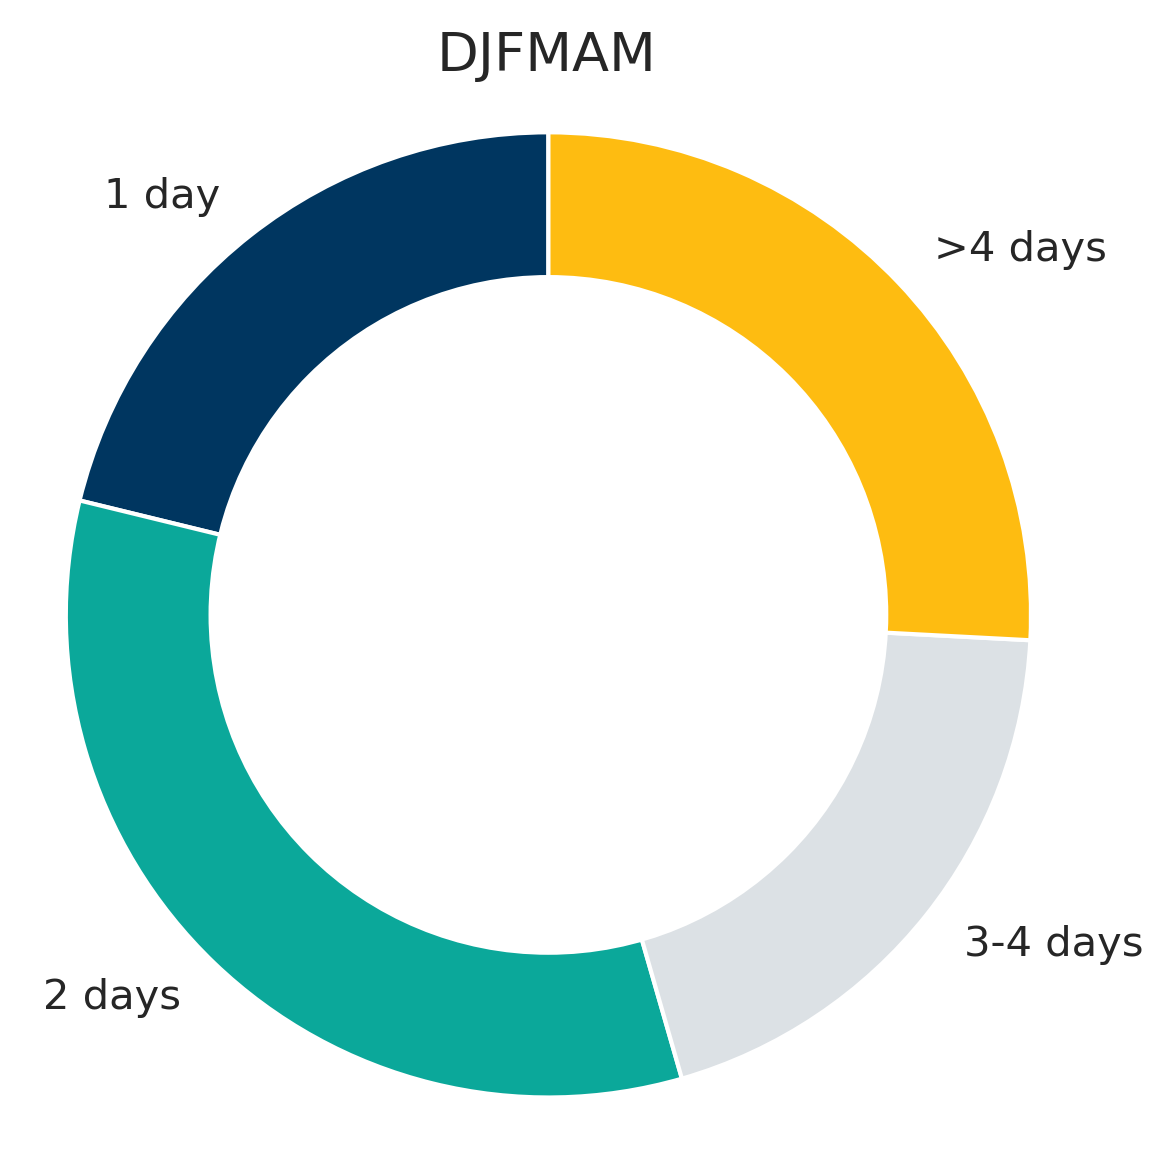

In [22]:
fname = path_to_figs + 'donut_plot_duration_freq'
fmt = 'png'

# Pie chart
plt_labels = ['DJFMAM']
labels = ['1 day', '2 days', '3-4 days', '>4 days']
#colors
colors = ['#003660','#0BA89A','#DCE1E5', '#FEBC11']
 
fig = plt.figure()
fig.set_size_inches((4.,4.))
fig.dpi = 300
nrows = 1
ncols = 1
nplots = nrows*ncols
for i in np.arange(nplots):
    ax = plt.subplot(nrows, ncols, i+1)
    ax.pie(sizes[i], colors = colors, labels=labels, autopct=None, startangle=90)
    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')  
    plt.title(plt_labels[i], fontsize=13)

plt.tight_layout()
# plt.show()

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=300)

plotFile = fname + '.png'
print(plotFile)

### Westerly Distubance Comparison

In [23]:
def resample_track_id(df):
    '''
    Returns an array that has a single AR track ID for each 24 hr
    
    '''
    df_tmp = wd_df['event_id']

    ## resample to 1D taking maximum of new column
    level_values = df_tmp.index.get_level_values
    df_tmp = df_tmp.groupby([level_values(i) for i in [0,1]]+[pd.Grouper(freq='1D', level=0)]).max()


    # date array with all days
    dates_allDays = pd.date_range(start='1979-01-01', end='2015-01-31', freq='1D')
    arr_allDays = np.zeros(len(dates_allDays), dtype=np.float)
    arr_allDays[:] = np.nan

    # Loop over AR days ID and match to list of ALL days 
    for i, date in enumerate(df_tmp.index.get_level_values(2)):
        idx = np.where(dates_allDays == date)
        arr_allDays[idx] = df_tmp.values[i]

    return arr_allDays

In [24]:
filename = path_to_data + 'CEDA/bitmap_era-interim-derived-wd-tracks.csv'
df2 = pd.read_csv(filename, header=29, skiprows=[29], parse_dates=['time'], skipfooter=1, engine='python')
df2 = df2.set_index(pd.to_datetime(df2.time))
df2

,event_id,lon,lat,intensity,size,eccentricity,signal,time,vorticity,timestep_id
time,,,,,,,,,,
1979-01-01 00:00:00,45,40.290852,37.471957,14426.318010,3.195122,0.235435,315.125969,1979-01-01 00:00:00,0.000067,0
1979-01-01 00:00:00,48,61.892062,31.935886,19019.216980,3.271355,0.064982,372.196027,1979-01-01 00:00:00,0.000079,0
1979-01-01 06:00:00,45,43.736661,36.014512,16910.263330,3.201646,0.154904,358.922838,1979-01-01 06:00:00,0.000074,1
1979-01-01 06:00:00,48,64.076665,31.806202,17289.631140,3.286019,0.039174,336.206203,1979-01-01 06:00:00,0.000073,1
1979-01-01 12:00:00,45,47.757141,34.824067,16786.617450,3.226879,0.158068,346.145316,1979-01-01 12:00:00,0.000071,2
...,...,...,...,...,...,...,...,...,...,...
2015-01-31 12:00:00,379773,96.866678,44.752343,12823.753090,3.351098,0.067031,229.623205,2015-01-31 12:00:00,0.000055,52718
2015-01-31 12:00:00,379850,99.100541,29.104065,9946.433741,3.278261,0.240604,192.133702,2015-01-31 12:00:00,0.000049,52718
2015-01-31 18:00:00,379761,61.183830,36.640286,14908.012550,3.204625,0.165131,316.832230,2015-01-31 18:00:00,0.000077,52719


In [25]:
# total number of WDs 
nevents2 = df2['event_id'].nunique()
print('Total number of events: ', nevents2)

Total number of events:  3090


In [26]:
wd_df = select_months(df2, 12, 5)
print('Total number of events in DJFMAM: ', wd_df['event_id'].nunique())


Total number of events in DJFMAM:  2631


In [27]:
df_tmp = wd_df['event_id']
## resample to 1D taking maximum of event_id
df_tmp = df_tmp.groupby([pd.Grouper(freq='1D', level=0)]).max()
wd_daily = df_tmp


In [28]:
# select only rows with WWD
idx = (wd_daily.values > 0)
wd_events = wd_daily.loc[idx]

# select only rows with AR
idx = (djfmam_df.ar > 0)
djfmam_df = djfmam_df.loc[idx]

In [29]:
x = wd_events.index
y = djfmam_df.index

WD_count = wd_events.loc[x.isin(y)]
perc1 = (len(WD_count)/len(wd_events))*100
print(perc1, '% of WWDs are associated with an AR')
      
AR_count = djfmam_df.loc[y.isin(x)]
perc2 = (len(AR_count)/len(djfmam_df))*100
print(perc2, '% of ARs are associated with a WWD')

10.350433526011562 % of WWDs are associated with an AR
75.49407114624506 % of ARs are associated with a WWD
